In [17]:
import os
if os.path.basename(os.path.abspath(".")) == "notebooks":
    os.chdir("..")

import argparse
import random
import shutil
import pprint
import time
import os
import cv2
import json
import pickle
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import datetime
import torchvision
from tqdm import tqdm
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid
import torch
from torch import autocast
from contextlib import contextmanager, nullcontext
from src.datasets import get_dataset
from src.foreground_masks import GMMMaskSuggestor
from src.preliminary_masks import preprocess_attention_maps
from src.visualization.utils import word_to_slice
from src.visualization.utils import MIMIC_STRING_TO_ATTENTION
from src.visualization.utils import model_to_viz
from log import logger, log_experiment
from sklearn.metrics import jaccard_score
from log import logger, log_experiment
from log import formatter as log_formatter
from tqdm import tqdm
import logging
from utils import get_compute_mask_args, make_exp_config, load_model_from_config, collate_batch, img_to_viz
from einops import reduce, rearrange, repeat
from pytorch_lightning import seed_everything
from mpl_toolkits.axes_grid1 import ImageGrid
from omegaconf import OmegaConf
from src.ldm.util import instantiate_from_config
from src.ldm.util import AttentionSaveMode
from src.ldm.models.diffusion.plms import PLMSSampler
from src.preliminary_masks import reorder_attention_maps, normalize_attention_map_size
from src.ldm.models.diffusion.ddim import DDIMSampler
from src.evaluation.utils import compute_metrics, compute_prediction_from_binary_mask
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import matplotlib.patches as patches
from src.datasets.utils import path_to_tensor
from src.ldm.encoders.modules import OpenClipDummyTokenizer

In [18]:
def get_latent_slice(batch, opt):
    ds_slice = []
    for slice_ in batch["slice"]:
        if slice_.start is None:
            ds_slice.append(slice(None, None, None))
        else:
            ds_slice.append(slice(slice_.start // opt.f, slice_.stop // opt.f, None))
    return tuple(ds_slice)

def apply_rect(img, x, y, h, w, color="red"):
    img = (img * 255).to(torch.uint8).numpy()
    img = rearrange(img, "c h w -> h w c")
    if color == "red":
        color = (255, 0, 0)
    elif color == "blue":
        color = (0, 0, 255)

    img = cv2.rectangle(img.copy(), [x, y], [x + h, y + w], color, 3)
    img = rearrange(img, "h w c -> c h w") / 255.
    return torch.tensor(img)


def add_viz_of_data_and_pred(images, batch, x_samples_ddim, opt):
    # append input
    x0_norm = torch.clamp((batch["x"] + 1.0) / 2.0, min=0.0, max=1.0).cpu()
    x0_norm = reduce(x0_norm, 'b c (h h2) (w w2) -> b c h w', 'mean', h2=opt.f, w2=opt.f)
    images.append(x0_norm)

    # append model output

    x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0).cpu()
    images.append(
        reduce(x_samples_ddim, 'b c (h h2) (w w2) -> b c h w', 'mean', h2=opt.f, w2=opt.f))

    # append gt mask
    images.append(
        reduce(batch["segmentation_x"], 'b c (h h2) (w w2) -> b c h w', 'max', h2=opt.f, w2=opt.f))


def contrast_to_noise_ratio(ground_truth_img, prelim_mask_large):
    gt_mask = ground_truth_img.flatten()
    pr_mask = prelim_mask_large.flatten()

    roi_values = pr_mask[gt_mask == 1.0]
    not_roi_values = pr_mask[gt_mask != 1.0]

    contrast = roi_values.mean() - not_roi_values.mean()
    noise = torch.sqrt(
        roi_values.var() / 2 + not_roi_values.var() / 2
    )
    cnr = contrast / noise
    return cnr


def check_mask_exists(mask_dir, samples):
    for i in range(len(samples["rel_path"])):
        path = os.path.join(mask_dir, samples["rel_path"][i] + ".pt")
        if not os.path.exists(path):
            return False
    return True

# Important Variables

In [19]:
log_dir = "notebooks/outputs/multi_class_segmentation/"
EXP_PATH = "experiments/chestxray/train_multilabel_hpc_arm01_ft.py"
MODEL_PATH = "/vol/ideadata/ed52egek/diffusionmodels/chest/arm/mlf-false-true-1-5e5-30000.ckpt"
#MODEL_PATH = "/vol/ideadata/ed52egek/diffusionmodels/chest/arm/mlf-false-true-0-5e5-30000.ckpt"
os.makedirs(log_dir, exist_ok=True)
opt = make_exp_config(EXP_PATH)


# Load Model

In [20]:
opt.dataset_args_test["base_dir"] = opt.dataset_args_test["base_dir"].replace("/home/atuin/b143dc/b143dc11/", "/vol/ideadata/ed52egek/")
dataset = get_dataset(opt, "test")
print(f"Dataset length: {len(dataset)}")

print(opt.config_path)
config = OmegaConf.load(f"{opt.config_path.replace('/home/atuin/b143dc/b143dc11', '/vol/ideadata/ed52egek')}")
config["model"]["params"]["use_ema"] = False
config["model"]["params"]["unet_config"]["params"]["attention_save_mode"] = "cross"
logger.info(f"Enabling attention save mode")

is_mlf = False
if hasattr(opt, "mlf_args"):
    is_mlf = opt.mlf_args.get("multi_label_finetuning", False)
    logger.info(f"Overwriting default arguments of config with {opt.mlf_args}")
    config["model"]["params"]["attention_regularization"] = opt.mlf_args.get("attention_regularization")
    config["model"]["params"]["cond_stage_key"] = opt.mlf_args.get("cond_stage_key")
    config["model"]["params"]["cond_stage_config"]["params"]["multi_label_finetuning"] = opt.mlf_args.get("multi_label_finetuning")

model = load_model_from_config(config, f"{MODEL_PATH}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
dataset.load_precomputed(model)
sampler = DDIMSampler(model)

Dataset length: 1133
/home/atuin/b143dc/b143dc11/pycharm/chest-distillation/experiments/chestxray/configs/v2-chest-training.yaml
2023-02-28 23:52:28,127 | 966120560.py-<module>-0009 | INFO | Enabling attention save mode
2023-02-28 23:52:28,128 | 966120560.py-<module>-0014 | INFO | Overwriting default arguments of config with {'multi_label_finetuning': True, 'cond_stage_key': 'finding_labels', 'append_invariance_tokens': False, 'single_healthy_class_token': True, 'attention_regularization': 0.0}
Loading model from /vol/ideadata/ed52egek/diffusionmodels/chest/arm/mlf-false-true-1-5e5-30000.ckpt
Global Step: 30000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 865.91 M params.
2023-02-28 23:52:43,031 | ddpm.py-__init__-0142 | INFO | Unconditional guidance probability: 0.0
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
2023-02-28 23:52:43,554 | fa

In [21]:
mask_suggestor = GMMMaskSuggestor(opt)

In [22]:
tokenizer = OpenClipDummyTokenizer(opt.seed, opt.mlf_args.get("append_invariance_tokens", False), opt.mlf_args.get("single_healthy_class_token", False))
model.cond_stage_model.set_multi_label_tokenizer(tokenizer)

In [23]:
precision_scope = autocast
rev_diff_steps = 40
sample = dataset[0]

sample["img"].size()
sample["finding_labels"]


'Pneumonia'

In [24]:
sample.keys()

dict_keys(['rel_path', 'finding_labels', 'dicom_id', 'bboxxywh', 'label_text', 'img_raw', 'img', 'bbox_img'])

In [25]:
sample["finding_labels"] = [sample["finding_labels"],]#.size()
sample["finding_labels"]

['Pneumonia']

In [26]:

with torch.no_grad():
    with precision_scope("cuda"):
        with model.ema_scope():
            images = model.log_images(sample, N=1, split="test", sample=False, inpaint=True,
                              plot_progressive_rows=False, plot_diffusion_rows=False,
                              use_ema_scope=False, cond_key="finding_labels", mask=1.,
                              save_attention=True)
            attention_maps = images.pop("attention")
            attention_images = preprocess_attention_maps(attention_maps, on_cpu=False)

mask_suggestor = GMMMaskSuggestor(opt)

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0


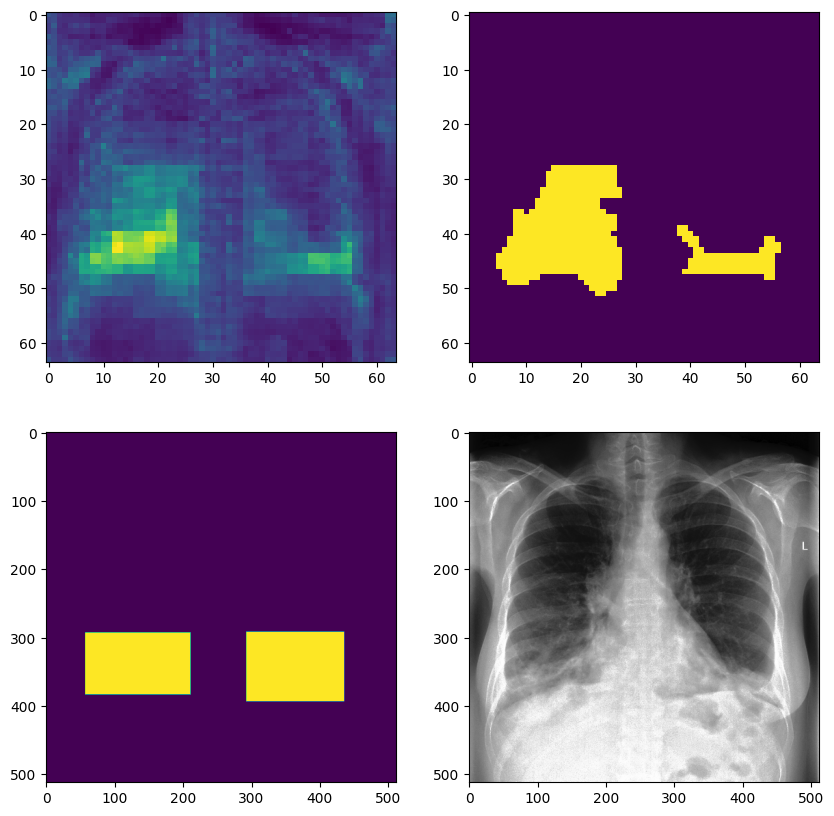

In [27]:

attention = attention_images[0]
token_positions = tokenizer.get_attention_map_location(sample["finding_labels"][0].split("|"))
tok_attentions = []
for token_position in token_positions:
    tok_attention = attention[-1 * rev_diff_steps:, :,
                    token_position:token_position+ 1]
    tok_attentions.append(tok_attention.mean(dim=(0, 1, 2)))
preliminary_attention_mask = torch.stack(tok_attentions).mean(dim=(0))
samples = dict(preliminary_mask=preliminary_attention_mask)
binary_mask = mask_suggestor(samples)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(preliminary_attention_mask.cpu())
ax[0,1].imshow(binary_mask.cpu())
ax[1,0].imshow(sample["bbox_img"])
ax[1,1].imshow((rearrange(sample["img_raw"][0],"c h w -> h w c") + 1) / 2)
plt.show()

In [28]:
with torch.no_grad():
    with precision_scope("cuda"):
        with model.ema_scope():
            images = model.log_images(sample, N=1, split="test", sample=False, inpaint=True,
                                          plot_progressive_rows=False, plot_diffusion_rows=False,
                                          use_ema_scope=False, cond_key="finding_labels", mask=1-binary_mask.to(torch.float16),
                                          save_attention=True)

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0


2023-02-28 23:53:08,337 | image.py-set_data-0720 | WARNING | Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-02-28 23:53:08,349 | image.py-set_data-0720 | WARNING | Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-02-28 23:53:08,355 | image.py-set_data-0720 | WARNING | Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


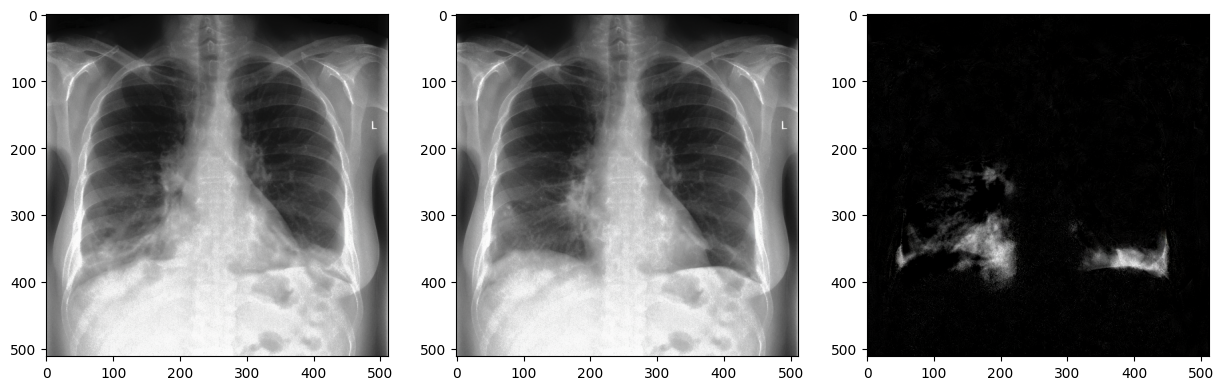

In [29]:
to_imag = lambda x: (rearrange(x, "1 c h w -> h w c").cpu().float() + 1) /2
inpainting_result = images["samples_inpainting"]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(to_imag(images["reconstruction"]))
ax[1].imshow(to_imag(images["samples_inpainting"]))
ax[2].imshow(rearrange(images["reconstruction"] - images["samples_inpainting"], "1 c h w -> h w c").cpu().float())

Healthy sample first

In [32]:
import torchxrayvision as xrv
import skimage
clf_model = xrv.models.DenseNet(weights="densenet121-res224-all").to("cuda")
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(), xrv.datasets.XRayResizer(224)])


def pred_model_output(inp):
    img = rearrange(inp, "c h w -> h w c")
    img = (img + 1) / 2 * 255
    img = img.clamp(0, 255.)
    img = img.cpu().numpy()
    img = xrv.datasets.normalize(img, 255)  # convert 8-bit image to [-1024, 1024] range
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = img.mean(2)[None, ...]  # Make single color channel
    else:
        img = img[None, ...]

    img = transform(img)
    img = torch.from_numpy(img).to("cuda")

    outputs = clf_model(img[None, ...])
    print(dict(zip(clf_model.pathologies,outputs[0].detach().cpu().numpy())))
    return outputs

from copy import deepcopy
with torch.no_grad():
    with precision_scope("cuda"):
        with model.ema_scope():
            print(sample["finding_labels"])
            sample["finding_labels"] = ["No Finding",]
            counterfactuals = model.log_images(sample, N=1, split="test", sample=False, inpaint=True,
                                          plot_progressive_rows=False, plot_diffusion_rows=False,
                                          use_ema_scope=False, cond_key="finding_labels", mask=1-binary_mask.to(torch.float16),
                                          save_attention=True)


print("==="*10 + "Reconstruction")
recon = pred_model_output(images["reconstruction"][0])
print("==="*10 + "Inpaint with: " + str(sample["finding_labels"]))
inpain = pred_model_output(images["samples_inpainting"][0])
print("==="*10 + "Counterfactuals")
inpain = pred_model_output(counterfactuals["samples_inpainting"][0])



Setting XRayResizer engine to cv2 could increase performance.
['No Finding']
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
==============================Reconstruction
{'Atelectasis': 0.8346484, 'Consolidation': 0.6953207, 'Infiltration': 0.606948, 'Pneumothorax': 0.56611073, 'Edema': 0.5234729, 'Emphysema': 0.5007963, 'Fibrosis': 0.53659046, 'Effusion': 0.8584039, 'Pneumonia': 0.63036406, 'Pleural_Thickening': 0.50456524, 'Cardiomegaly': 0.605351, 'Nodule': 0.5204295, 'Mass': 0.5403491, 'Hernia': 0.09475774, 'Lung Lesion': 0.5835463, 'Fracture': 0.5091456, 'Lung Opacity': 0.76885766, 'Enlarged Cardiomediastinum': 0.5368368}
==============================Inpaint with: ['No Finding']
{'Atelectasis': 0.680449, 'Consolidation': 0.552755, 'Infiltration': 0.55828774, 'Pneumothorax': 0.54038763, 'Edema': 0.46606275, 'Emphysema': 0.5014116, 'Fibrosis': 0.54394865, 'Effusion': 0.60676956, 'Pneumonia': 0.5815501, 'Pleural_Thicken

In [31]:
import torchxrayvision as xrv
import skimage
clf_model = xrv.models.DenseNet(weights="densenet121-res224-all").to("cuda")
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(), xrv.datasets.XRayResizer(224)])

results = []
img = rearrange(images["reconstruction"][0], "c h w -> h w c")
img = (img + 1) / 2 * 255
img = img.clamp(0, 255.)
img = img.cpu().numpy()
img = xrv.datasets.normalize(img, 255)  # convert 8-bit image to [-1024, 1024] range
if len(img.shape) == 3 and img.shape[2] == 3:
    img = img.mean(2)[None, ...]  # Make single color channel
else:
    img = img[None, ...]

img = transform(img)
img = torch.from_numpy(img).to("cuda")

outputs = model(img[None, ...])
dict(zip(model.pathologies,outputs[0].detach().cpu().numpy()))

Setting XRayResizer engine to cv2 could increase performance.


TypeError: forward() missing 1 required positional argument: 'c'